# PyCBC Tutorial: Generating Waveforms and Matched Filtering
### Alex Nitz

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how to find a specific signal in LIGO data. We present how to generate the waveform of a gravitational-wave merger and matched filtering, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Guassian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

#### Getting the software environment setup

PyCBC is installable through pip, but also relies on portions of the [LALSuite](https://git.ligo.org/lscsoft/lalsuite) c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

### Catalog of Binary Mergers ###

PyCBC provides an [API](http://pycbc.org/pycbc/latest/html/catalog.html) to look at the catalog of binary mergers a few examples below. Some key information, such as the 'chirp' mass of a binary merge can be retrieved.

#### What binary mergers are in the catalog? ####

In [2]:
from pycbc import catalog

### List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)

GW151012
GW170608
GW170729
GW150914
GW151226
GW170814
GW170817
GW170104
GW170809
GW170818
GW170823


#### How can I get parameters? ####

One can also retrieve some of the basic parameters of each source
from the catalog directly as follows. Note that all parameters are given
in the *source* frame. This means that they include the effect of redshift.

[15.2    7.9   35.7   28.6    8.9   24.2    1.186 21.5   25.    26.7
 29.3  ]
GW170817: 1.186
[u'files', u'distance', u'a_final', u'mass1', u'tc', u'far_gstlal', u'far_pycbc', u'mass2', u'mchirp', u'snr_gstlal', u'redshift', u'far_cwb', u'utctime', u'L_peak', u'sky_size', u'mfinal', u'E_rad', u'chi_eff', u'snr_pycbc', u'snr_cwb']


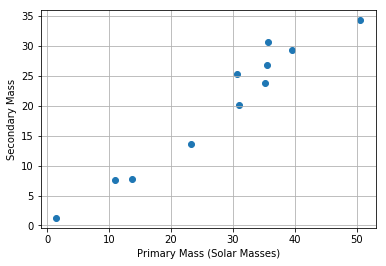

In [3]:
%matplotlib inline
import pylab

# Either from the catalog as a whole
c = catalog.Catalog()
mchirp = c.median1d('mchirp')
print(mchirp)

# or from a specific merger
m = catalog.Merger("GW170817")
mchirp_gw170817 = m.median1d('mchirp')
print('GW170817: {}'.format(mchirp_gw170817))

# print parameters that can be read
print m.data.keys()

pylab.scatter(c.median1d('mass1'), c.median1d('mass2'))
pylab.xlabel("Primary Mass (Solar Masses)")
pylab.ylabel("Secondary Mass")
pylab.grid()

#### Transform Mass Parameters into the Detector Frame

By default the above interface returns parameters in the *source* frame. Due to cosmological redshift, gravitational-waves are stretched as they travel. This causes the observed waveform to be different in the detector frame. This corresponds to an observed change in the mass parameters (for example). However, the relationship is fairly straighforward.

In [4]:
m = catalog.Merger('GW150914')
source_mchirp = m.median1d('mchirp')
redshift = m.median1d('redshift')
det_mchirp = source_mchirp * (1 + redshift)

print('Chirp Mass of GW150914')
print('Source Frame: {} Solar Masses'.format(source_mchirp))
print('Detector Frame: {} Solar Masses'.format(det_mchirp))

Chirp Mass of GW150914
Source Frame: 28.6 Solar Masses
Detector Frame: 31.174 Solar Masses


### Accessing LIGO/Virgo data

In this section, we will look into how to read detector data from the LIGO and Virgo instruments using the PyCBC API. It is possible to both get data around specific events, and also from the full data sets which have been released which cover the S5/S6/O1 LIGO observing runs. Data will be returned as [pycbc TimeSeries objects.](http://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries)

#### Getting Data Around  Specific Binary Merger in the Catalog

One can directly retrieve data around a specific even. Typically this data is centered on the event, though restrictions may apply which have not allowed this. This method by default gets the smallest version of the dataset. If additional data or specific versions are required, please see the following two additional ways to access data.

Duration: 32.0s Start: 1126259447 End: 1126259479


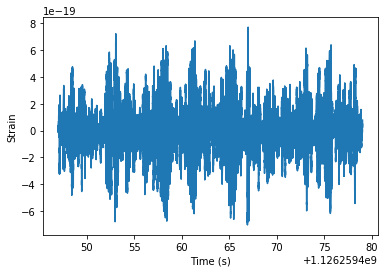

In [5]:
m = catalog.Merger("GW150914")

# Get the time series data around GW150914 from Hanford
# 'ts_han' is a pycbc.types.TimeSeries object which contains
# gravitational-wave strain in this instance and has metadata
# such as the start time, and sample rate.
ts_han = m.strain('H1')

# And now livingston
ts_liv = m.strain('L1')

# We can see how much data was returned and its boundaries
# Note: All times are given in seconds since the GPS time epoch
print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

# We can directly plot the time series as follows
pylab.plot(ts_han.sample_times, ts_han)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

#### Getting Data from S5 / S6 / O1

In this section we show how to read data from the bulk data release by LIGO. This currently covers the periods of the S5, S6, and O1 analyses.

In [ ]:
from pycbc.frame import query_and_read_frame

# Retrieve the approximate time of the merger
m = catalog.Merger("GW150914")
start = m.time - 32
end = m.time + 32

# Get 64 seconds of data roughly around GW150914
# The start / end time may be any in the publicly available data sets.
ts = query_and_read_frame('LOSC', 'H1:LOSC-STRAIN', start, end)

# If we wanted to retreive data from the Livingston detector
# we'd use the following command instead
# ts = query_and_read_frame('LOSC', 'L1:LOSC-STRAIN', start, end)

print("Returned {}s of data at {}Hz".format(ts.duration, ts.sample_rate))

#### Directly Reading gravitational-wave Frame Files

If you store LIGO data on your own computer then you can directly read in the data as follows.

In [ ]:
# We'll first download some data for this demonstration
!curl -O -J -L https://losc.ligo.org/s/events/LVT151012/H-H1_LOSC_4_V2-1128678884-32.gwf

In [ ]:
from pycbc.frame import read_frame

# Read the data directly from the Gravitational-Wave Frame (GWF) file.
file_name = "H-H1_LOSC_4_V2-1128678884-32.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:LOSC-STRAIN"

start = 1128678884
end = start + 32

ts = read_frame(file_name, channel_name, start, end)

### Generate your first gravitational waveform !

Here we'll generate the gravitational waveform using one of the available waveform approximants. These can be generated as a time series using [`get_td_waveform`](http://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform). There are some additional examples using this interface [here](http://pycbc.org/pycbc/latest/html/waveform.html). The key parameters are the masses of the binary (given in solar masses), the time between samples (in seconds), the starting gravitational-wave frequency (Hz) and the name of the approximant we'd like to generate. A variety of approximants are available that include different physical effects. A full review of the different models is outside of the scope of this tutorial.

In this example, we've chosen to use the 'SEOBNRv4_opt' model. There are many others available as well with different methodologies and which include different physical effects. This is an implementation of the model introduced [in this paper](https://arxiv.org/pdf/1611.03703.pdf). It models the gravitational waveform of inspiralling and merging black holes, and includes the ability for each black hole to spin in the same direction as the orbit (aligned spin).

In [ ]:
from pycbc.waveform import get_td_waveform

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

We can see that in the this case, the two polariations differ only by the phase of the signal. This holds for systems where the orbital plane of the binary doesn't precess. In the zoom-in plot, we can see the merger itself and the ringdown that follows.

### How does the waveform change with the mass of the binary?

Below you can see how the length of the waveform increases for lower mass binary mergers.

In [ ]:
# Component mass of each binary component. We'll simplify here and assume that each 
# component of the binary has the same mass. Again, units are in solar masses.
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)
    
    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### Changing the distance of the waveform

The distance of the waveform is also selectable when you generate a waveform. The units used are Megaparsecs. Keep in mind that no redshift effects are taken into account here, so there is a simple linear relationship between distance and amplitude

In [ ]:
for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    pylab.plot(hp.sample_times, hp, label='$Distance=%sMpc$' % d)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### Looking for a specific signal in the data

If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method in Gaussian noise to extract the siganl. Even when the parameters of the signal are unkown,  one can test for each set of parameters one is interesting in finding.

#### preconditioning the data 
 
The purpose of this is to reduce the dynamic range of the data and  supress low freqeuncy behavior which can introduce numerical artefacts. We may also wish to resample the data if high frequency content is not important.

In [ ]:
# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

#### filter wraparound 

Note the spike in the data at the boundaries. This is caused by the highpass and resampling stages filtering the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. Since the data itself has a discontinuity (i.e. it is not cyclic) the filter itself will ring off for a time up to the length of the filter. 

Even if a visible transient is not seen, we want to avoid filters that act on times which are not causally connect. To avoid this we trim the ends of the data sufficiently to ensure that they do not wraparound the input. We will enforce this requirement in all steps of our filtering.

In [ ]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

#### calculate the power spectral density

Optimal matched filtering requires weighting the frequency components of the potential signal and data by the noise amplitude. We can view this as filtering the data with the time series equivelant of 1 / PSD. To ensure that we can control how much applying this filter to the data, we window the time domain equivelant of the PSD to a specific length. This has the effect of losing some information about line behavior in the detector. However, since our signal spans a large frequency range, and lines are narrow, this is a negligible effect.

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(30, 1024)

#### make your signal model

Conceptually, matched filtering involves laying the potential signal over your data and integrating (after weighting frequencies correctly). If there is a signal in the data that aligns with your 'template', you will get a large value when integrated over.

In [ ]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()

#### calculating the signal-to-noise time series

In this section we will now calculate the signal-to-noise time series for our template. We'll take care to handle issues of filter corruption / wraparound by truncating the output time series. We need to account for both the length of the template and 1 / PSD.

In [ ]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Aligning and Subtracting the Proposed Signal

In the previous section we found a peak in the signal-to-noise for a proposed binary black hole merger. We can use this SNR peak to align our proposal to the data, and to also subtract our proposal from the data.

In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#### Visualize the overlap between the signal and data

To compare the data and signal are on equal footing, and to concentrate on the frequency range that is important, we will whiten both the template and the data, then bandpass both the data and template between 30-300 Hz. In this way, any signal that is in the data is transformed in the same way that the template is.

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

#### Subtracting the signal from the data

Now that we've aligned the template we can simply subtract it. Let's see below how that looks in the time-frequency plots!

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100,
                                           qrange=(8, 8),
                                           frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

## Challenge Problems!

Use the methods demonstrated above to see if you can calculate the SNR
time series in the following data sets. What is the SNR of each signal?
Which template matched which data?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass2 (equal mass) and that each component mass is one of 22, 36, or 50.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [ ]:
# Download the challenge set files

import urllib

def get_file(fname):
    url = "http://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    urllib.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_2.gwf', 'PyCBC_T2_3.gwf']

for fname in files:
    get_file(fname)